# 2 - OPES metad
Use OPES_METAD and OPES_METAD_EXPLORE to enhance sampling of collective variables.
</br>
The systems used are alanine dipeptide in vacuum (ala2), and alanine tetrapeptide in vacuum (ala4).

In [1]:
root_path = '/import/a12/users/minvernizzi/PLUMED-masterclass/masterclass-22-03/'
root_path = '../'

import numpy as np
import plumed

import sys
sys.path.append(root_path + 'scripts')
from calcFES import calcFES, calcDeltaF, calcESS

In [86]:
#reuse same plumed kernel, to avoid multiple warnings
PLUMED_KERNEL=plumed.Plumed()
from functools import partial
plumed.read_as_pandas = partial(plumed.read_as_pandas, kernel=PLUMED_KERNEL)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/mi/minvernizzi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


In [29]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

#set bigger font sizes
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIG_SIZE = 15
plt.rc('font', size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)   # fontsize of the figure title

try:
# https://github.com/luigibonati/fessa-color-palette/blob/master/fessa.py
    import fessa
    plt.set_cmap('fessa')
except:
    pass # no big deal

<Figure size 432x288 with 0 Axes>

In [51]:
methods = ['opes', 'explore', 'metad']
labels = {'opes' : 'OPES_METAD', 'explore' : 'OPES_METAD_EXPLORE', 'metad' : 'METAD'}
# colors = {'opes' : 'C{}'.format(1), 'explore' : 'C{}'.format(2), 'metad' : 'C{}'.format(0)}
colors = {'opes' : "#E69138", 'explore' : "#674EA7", 'metad' : "#6AA84F"}

In [87]:
KB = 0.0083144621
T0 = 300
BETA0 = 1/(KB*T0)
KBT = KB*T0

DF = 9.04
FES1D = plumed.read_as_pandas(root_path+'inputs-ala2/ref-fes1D.dat')
FES2D = plumed.read_as_pandas(root_path+'inputs-ala2/ref-fes2D.dat')

## Biasing $\phi$

In [203]:
folder_ = root_path + '2-opes_metad/phi-%s/'

colvars = {}
for method in methods[::2]: #skip explore for now
    colvars[method] = plumed.read_as_pandas(folder_%method+'COLVAR')

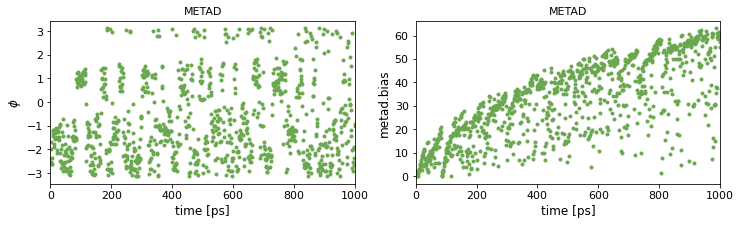

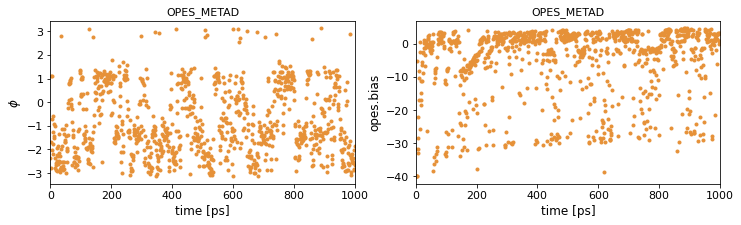

In [204]:
def plot_colvar(ax, method, cv, fmt='.', colvars=colvars):
    colvar = colvars[method]
    ax.plot(colvar['time'], colvar[cv], fmt, color=colors[method], label=cv)
    ax.set_xlim(colvar['time'].min(), colvar['time'].max())
    ax.set_xlabel('time [ps]')
    if cv == 'phi':
        ax.set_ylabel('$\phi$')
    elif cv == 'psi':
        ax.set_ylabel('$\psi$')
    else:
        ax.set_ylabel(cv)
    ax.set_title(labels[method])

def plot_two_cvs(method, cv1, cv2, fmt='.', colvars=colvars):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches((12, 3))
    plot_colvar(ax1, method, cv1, fmt, colvars=colvars)
    plot_colvar(ax2, method, cv2, fmt, colvars=colvars)
    plt.show()

plot_two_cvs('metad', 'phi', 'metad.bias')
plot_two_cvs('opes', 'phi', 'opes.bias')

Now let's check the other output components of the OPES_METAD run.

The `rct` quantity is defined as the one in METAD, and calculated as an ensemble average:
$$c(t)=\frac{1}{\beta}\log \left[\frac{1}{n}\sum_k^n e^{\beta V_k(s_k)}\right]$$
Contrary to METAD, it converges to a constant as the bias becomes quasi-static.
Thus, it can be a quick indication of how things are going.

The `zed` term starts from 1 and changes significantly only when a new region of CV space is sampled. It also can be a handy indicator, especially when biasing multiple CVs. The details of how its calculated are in the supporting information of Ref [66](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00497).

Here is how these two terms look like:

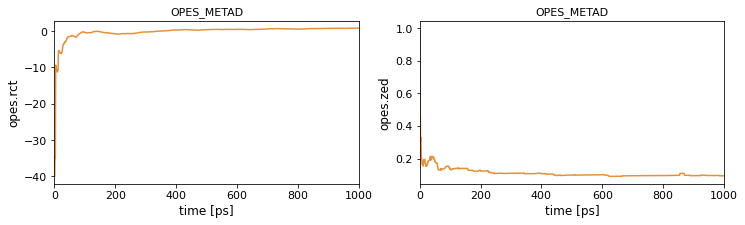

In [207]:
#some extra information about the OPES run
plot_two_cvs('opes', 'opes.rct', 'opes.zed', '-')

The effective sample size `neff` can also be stored. In a good run it should always increase, with a fixed ratio to the number of samples, that depends on the chosen target distribution.
`neff` is used to determine the shrinking of the bandwidth, according to Eq.6 of Ref.[66](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00497). 

The number of compressed kernels used to represent the probability estimate is stored in `nker`. This should be significantly smaller than the total number of deposited kernels, which is equal to the number of iterative steps $n$ ($n=1000$ in this example). As long as the bandwidth slowly shrinks it should slowly increase. This leads to a more accurate probability estimate, especially if the FES has small features.
If this is not the case, or if you plan a very long simulation, it is possible to set a `SIGMA_MIN`, and the bandwidth will not decrease further. Also, if a simulation already looks good one can use the `FIXED_SIGMA` keyword when restarting, and keep the bandwidth constant to limit the growth of `nker`.

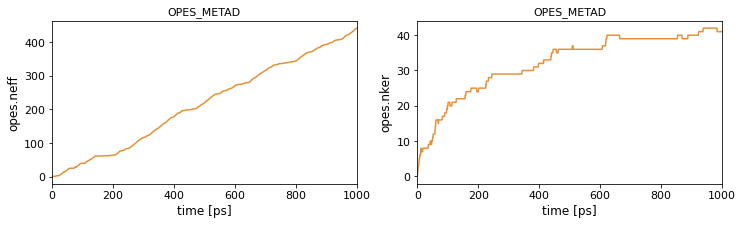

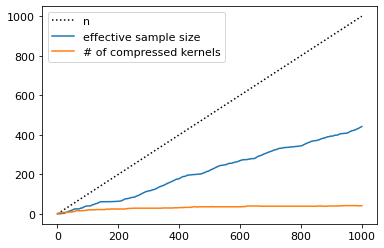

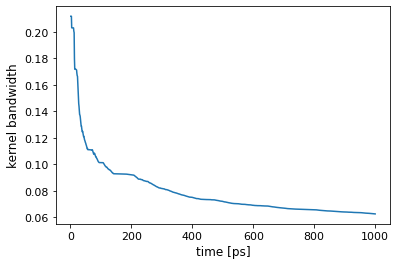

In [210]:
#some extra information about the OPES run
plot_two_cvs('opes', 'opes.neff', 'opes.nker', '-')

plt.plot(colvars['opes']['time'], colvars['opes']['time'], ':k', label='n')
plt.plot(colvars['opes']['time'], colvars['opes']['opes.neff'], label='effective sample size')
plt.plot(colvars['opes']['time'], colvars['opes']['opes.nker'], label='# of compressed kernels')
plt.legend()
plt.show()

kernels = plumed.read_as_pandas(folder_%'opes'+'KERNELS')
plt.plot(kernels['time'], kernels['sigma_phi'])
plt.xlabel('time [ps]')
plt.ylabel('kernel bandwidth')
plt.show()

Now let's look at some free energy estimates.

As usual in metadynamics, the bias potential at time t, $V_t(\phi)$, can be used to estimate the FES:
$$F_t(\phi)=-(1-1/\gamma)V_t(\phi)$$
Its time evolution gives us an idea of the different behaviour of the two methods. In OPES the bias adapts quickly, and then only small adjustments are made. It also does not grow much above the chosen BARRIER.

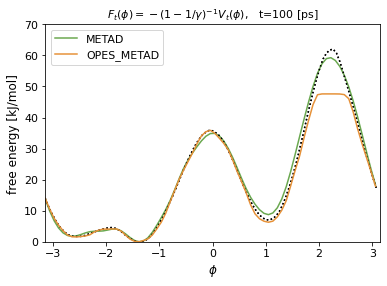

In [206]:
#Let's see how the bias evolves in time
try:
    grid_opes = plumed.read_as_pandas(folder_%'opes'+'fes_running/fes_100.dat', usecols=[0]).to_numpy()
except:
    myfolder = folder_%'opes'
    !mkdir {myfolder}fes_running
    !{root_path}scripts/FES_from_State.py --state {myfolder}STATE --temp {T0} --all_stored --bin 75 -o {myfolder}fes_running/
    grid_opes = plumed.read_as_pandas(folder_%'opes'+'fes_running/fes_100.dat', usecols=[0]).to_numpy()
try:
    grid_metad = plumed.read_as_pandas(folder_%'metad'+'fes_running/fes_100.dat', usecols=[0]).to_numpy()
except:
    myfolder = folder_%'metad'
    !mkdir {myfolder}fes_running
    !plumed sum_hills --hills {myfolder}HILLS --mintozero --bin 75 --outfile {myfolder}fes_running/fes_ --stride 10
    for i in reversed(range(100)): #fes_99.dat and fes_100.dat are equal
        !mv {myfolder}fes_running/fes_{i}.dat {myfolder}fes_running/fes_{i+1}.dat
    grid_metad = plumed.read_as_pandas(folder_%'metad'+'fes_running/fes_100.dat', usecols=[0]).to_numpy()

#now the plotting
def plot_fes1D(grid, fes, max_fes=70, ref_fes=True, **kwargs):
    if ref_fes:
        plt.plot(FES1D.iloc[:,0], FES1D.iloc[:,1],':k')
    plt.plot(grid, fes, **kwargs)
    plt.xlim(-np.pi, np.pi)
    plt.ylim(0, max_fes)
    plt.xlabel('$\phi$')
    plt.ylabel('free energy [kJ/mol]')

for i in range(100):
    clear_output(wait=True)
    fes_metad = plumed.read_as_pandas(folder_%'metad'+f'fes_running/fes_{i+1}.dat', usecols=[1]).to_numpy()
    fes_opes = plumed.read_as_pandas(folder_%'opes'+f'fes_running/fes_{i+1}.dat', usecols=[1]).to_numpy()
    plt.title(f'$F_t(\phi)=-(1-1/\gamma)^{{-1}}V_t(\phi)$,   t={i+1} [ps]')
    plot_fes1D(grid_metad, fes_metad, color=colors['metad'], label=labels['metad'])
    plot_fes1D(grid_opes, fes_opes, color=colors['opes'], label=labels['opes'])
    plt.legend(loc='upper left')
    plt.show()

We can also obtain the FES via reweighting. This is the suggested method for OPES, while for METAD several different reweighting schemes have been proposed, we consider two of the most popular.

We assume that after an initial transient the bias is quasi-static. In this case, where a good CV is used, this is a good assumption for both OPES and METAD.

We use a weighted kernel density estimation, similar to the one available in the PLUMED driver.

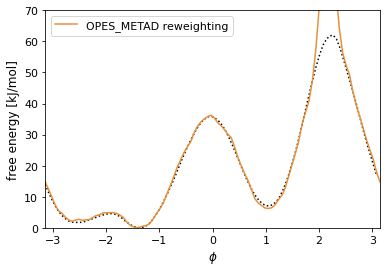

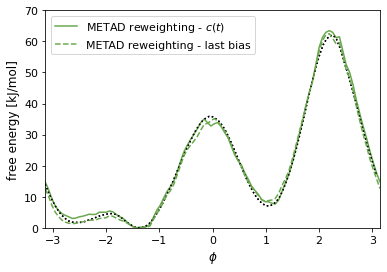

In [202]:
#reweighting is the suggested way to estimate the FES in OPES.
transient = 200
bandwidth = 0.05
grid_phi = np.linspace(-np.pi, np.pi, 100)

#opes
phi = colvars['opes']['phi'][transient:]
logweights = colvars['opes']['opes.bias'][transient:]/KBT
fes_opes = KBT*calcFES(grid_phi, bandwidth, phi, logweights, periodic=True)

plot_fes1D(grid_phi, fes_opes, label='OPES_METAD reweighting', color=colors['opes'])
plt.legend()
plt.show()

#metad has various ways for reweighting...
phi = colvars['metad']['phi'][transient:]
#rct reweighting:
logweights = colvars['metad']['metad.rbias'][transient:]/KBT
fes_metad_rct = KBT*calcFES(grid_phi, bandwidth, phi, logweights, periodic=True)
#last bias reweighting:
gamma = float(plumed.read_as_pandas(folder_%'metad'+'HILLS', usecols=['biasf']).iloc[0])
fes_metad_df = plumed.read_as_pandas(folder_%'metad'+f'fes_running/fes_{100}.dat', usecols=[0,1])
last_bias = -(1-1/gamma)*fes_metad_df.iloc[:,1]
logweights = np.interp(phi, fes_metad_df.iloc[:,0], last_bias)/KBT
fes_metad_rlb = KBT*calcFES(grid_phi, bandwidth, phi, logweights, periodic=True)

plot_fes1D(grid_phi, fes_metad_rct, color=colors['metad'], label='METAD reweighting - $c(t)$ ')
plot_fes1D(grid_phi, fes_metad_rlb, color=colors['metad'], ls='--', label='METAD reweighting - last bias')
plt.legend()
plt.show()

So, when using a good collective variable in 1D, both methods work great, and all the FES estimates are pretty accurate even with such a short simulation.
We can try to run this also for OPES_METAD_EXPLORE, and we will find similar results.

## Biasing more than one CV
We now show how OPES handles higher dimensional biases. We still use good CVs.

First we visualize the kernel compression in 2D, using alanine dipeptide $\phi$ and $\psi$ angles.
Then we will sample the bigger brother of ala2, alanine tetrapeptide (ala4), using all three of its $\phi$ angles.

In [ ]:
folder_ = 'phi_psi-%s/'

In [ ]:
#some plotting functions
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection

def plot_ala2_kernels(ax, kernels, scale=1, max_fes=40/KBT, period=2*np.pi):
    def add_kernels(dx=0, dy=0):
        pc = PatchCollection([ Ellipse(xy=(ker[1]-dx,ker[2]-dy), width=ker[3], height=ker[4]) for ker in kernels ])
        pc.set_array(np.minimum(max_fes, -scale*np.log(kernels[:,5]/max(kernels[:,5]))))
        pc.set_clim((0, max_fes))
        ax.add_collection(pc)
        return pc
    pc = add_kernels()
    if period is not None:
        add_kernels( period, 0)
        add_kernels(-period, 0)
        add_kernels(0,  period)
        add_kernels(0, -period)
    ax.set_aspect('equal')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$\psi$')
    ax.grid(ls='--')
    return pc

def plot_ala2_fes(ax, fes, max_fes=40/KBT):
    im = ax.imshow(fes, vmax=max_fes, origin='lower', extent=(-np.pi,np.pi,-np.pi,np.pi))
    cb = fig.colorbar(im, ax=ax)
    ax.set_aspect('equal')
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$\psi$')
    return cb

In [ ]:
#load both STATE files and the FES estimates
def load_states(filename):
    #check if OPES_METAD, or OPES_METAD_EXPLORE and set kernels scaling
    f = open(filename, 'r')
    line = f.readline() #fields
    line = f.readline() #action
    if line.split()[3] == 'OPES_METAD_state':
        scale = 1
    elif line.split()[3] == 'OPES_METAD_EXPLORE_state':
        line = f.readline()
        scale = float(line.split()[3]) #biasfactor
    else:
        assert False, filename+' is not an OPES STATE file'
    f.close()
    #read state file
    all_kernels = plumed.read_as_pandas(filename).to_numpy()
    times = np.unique(all_kernels[:,0])
    return all_kernels, scale, times

kernels_opes, _, times = load_states(folder_%'opes'+'STATE')
kernels_expl, scale, _ = load_states(folder_%'explore'+'STATE')

fes_folder = folder_+'fes_running/'
def load_fes(method, tot, fes_folder=fes_folder, state_filename=state_filename):
    try:
        filename = fes_folder%method+f'fes_{1}.dat'
        X = plumed.read_as_pandas(filename, usecols=[0]).to_numpy()
    except:
        !mkdir {fes_folder%method}
        !{root_path}scripts/FES_from_State.py --temp {T0} --all_stored -f {state_filename%method} -o {fes_folder%method}
        filename = fes_folder%method+f'fes_{1}.dat'
        X = plumed.read_as_pandas(filename, usecols=[0]).to_numpy()
    fes = []
    for i in range(tot):
        filename = fes_folder%method+f'fes_{1+i}.dat'
        fes_i = plumed.read_as_pandas(filename, usecols=[2]).to_numpy()/KBT
        nbins = int(np.sqrt(len(fes_i)))
        fes.append(fes_i.reshape(nbins, nbins))
    return X.reshape(nbins,nbins), fes
        
X, fes_opes = load_fes('opes', len(times))
_, fes_expl = load_fes('explore', len(times))
_, fes_metad = load_fes('metad', len(times))

In [ ]:
# for t in times:
#     clear_output(wait=True)
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches((10, 4))
    
#     ker = kernels_opes[kernels_opes[:,0]==t]
#     ax1.set_title(f'OPES_METAD\ntime = {t:g} ps\n tot kernels: {len(ker)}')
#     pc = plot_ala2_kernels(ax1, kernels_opes[kernels_opes[:,0]==t])
#     fig.colorbar(pc, ax=ax1)
    
#     ker = kernels_expl[kernels_expl[:,0]==t]
#     ax2.set_title(f'OPES_METAD_EXPLORE\ntime = {t:g} ps\n tot kernels: {len(ker)}')
#     pc = plot_ala2_kernels(ax2, kernels_expl[kernels_expl[:,0]==t], scale)
#     fig.colorbar(pc, ax=ax2)
#     # time.sleep(1)
#     plt.show()

In [ ]:
max_fes = 40/KBT

for i,t in enumerate(times):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches((10, 4))
    
    ker = kernels_opes[kernels_opes[:,0]==t]
    ax1.set_title(f'tot kernels: {len(ker)}')
    pc = plot_ala2_kernels(ax1, ker, scale=1, max_fes=max_fes)
    fig.colorbar(pc, ax=ax1)
    
    ax2.set_title(f'time = {t:g} ps')
    plot_ala2_fes(ax2, fes_opes[i], max_fes=max_fes)
    plt.show()

In [ ]:
for i,t in enumerate(times):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches((10, 4))
    
    ker = kernels_expl[kernels_expl[:,0]==t]
    ax1.set_title(f'tot kernels: {len(ker)}')
    pc = plot_ala2_kernels(ax1, ker, scale=scale, max_fes=max_fes)
    fig.colorbar(pc, ax=ax1)
    
    ax2.set_title(f'time = {t:g} ps')
    plot_ala2_fes(ax2, fes_expl[i], max_fes=max_fes)
    plt.show()

In [ ]:
for i,t in enumerate(times):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches((10, 4))
    
    ax1.set_title(f'time = {t:g} ps')
    plot_ala2_fes(ax1, fes_metad[i], max_fes=max_fes)
    
    ax2.set_title(f'time = {t:g} ps')
    plot_ala2_fes(ax2, fes_expl[i], max_fes=max_fes)
    plt.show()

In [ ]:
deltaF_opes = np.array([calcDeltaF(fes, X<0) for fes in fes_opes])
deltaF_expl = np.array([calcDeltaF(fes, X<0) for fes in fes_expl])
deltaF_metad = np.array([calcDeltaF(fes, X<0) for fes in fes_metad])

plt.plot(times, deltaF_opes, label='OPES')
plt.plot(times, deltaF_expl, label='OPES EXPLORE')
plt.plot(times, deltaF_metad, label='METAD')
plt.axhline(DeltaF/KBT, ls=':', color='black')
plt.axhspan(DeltaF/KBT-.5, DeltaF/KBT+.5, alpha=.1, color='black')
plt.xlim(0, times[-1])
plt.xlabel('Time [ps]')
plt.ylabel('$\Delta F$ [k$_B$T]')
plt.legend()
plt.show()